# tsma 4: Clustering and phase diagram
All the examples are done with an implementation of Gross's model of 2022 : https://doi.org/10.1016/j.ecolecon.2010.03.021

This analysis is a homemade one, no articles are associated yet and the code is not optimized yet.

### requirements

In [1]:
from tsma.models.gross2022 import Gross2022 as model
from tsma.collect.output_management import query_nparameters, query_simulations

parameters = {
    "b_margin": 0.05,
    "hh_cons_propensity": 1,
    "norisk_interest": 0,
    "tgt_capital_ratio": 0.1,
    "smooth_interest": 15,
    "beta": 1, 
}

hyper_parameters = {"f_n": 200, "hh_n": 20000, "t_end": 100, "seed": 33}

initial_values = {
    "wages_0": 1,
    "wages_1": 1,
    "prices_0": 1.01,
    "prices_1": 1,
}

m = model(parameters, hyper_parameters, initial_values)
output = m.simulate(t_end = 40, seed = 10, save = True, overwrite = False)
varnames = list(output)
nvar = len(varnames)

## 1 Definition of:

- The variable selections **v**
- The embeddings **e**
- The metrics **m**

### The variable selections

Here certains set of variables are selected for the clustering. Indeed one can take only
flow variables for the stability of the metric computation for instance. More over PCA
can be used to reduce the dimensionality to limit the dimensionality curse.

In [2]:
low_valued_vars = [
    16,  # unemployment_rate
    17,  # n_active
    19,  # rollover
    20,  # full_debt_service
    48,  # real_GDP_growth
    47,  # real_wage
    1,  # wage_inflation
    3,  # inflation
    30,  # mean_inflation
    31,  # mean_wage_inflation
    14,  # sPD
    15,  # sLGD
    8,  # interest
    23,  # Debt_to_GDP
    26,  # f_profit_share_GDP
    27,  # w_share_GDP
    29,  # firms_interest_coverage
    32,  # count_newloans
    33,  # count_topups
    10,  # capital_ratio
    42,  # mean_f_capr
]

dct_v = {
    "v1": low_valued_vars,  # flow variables with low values
    "v2": low_valued_vars + [34, 40],  # with mean_demand and mean_loan
}

# all variables
dct_v["v3"] = dct_v["v2"] + list(
    set(range(len(varnames))) - set(dct_v["v2"])
)

### The embeddings

The embedding add information to considered during the clustering. For instance if
the metric is purely geometrical, which means that the speed of time has no influence on
the output, it can be useful to add time as a feature.\
Here the embedding are functions on the outputs.

**embedding_lead_lag** shows very good results in the literature. It adds laged values of the variables.

In [3]:
from analyses.clustering import embedding_lead_lag

dct_e = {
    "e1": lambda outputs : outputs,
    "e2": lambda outputs : embedding_lead_lag(outputs, nlag = 1), 
    "e3": lambda outputs : embedding_lead_lag(outputs, nlag = 2), 
}

### The metrics 

A metric defines what 'similar' means for two time series. It can be the euclidean distance for instance.\
The Metric class is used to buid the metrics. Here Dynamic time warping and signature metric are implemented.\
See analyses.metrics to create your own classes.

In [4]:
from tsma.analyses.metrics import Ts_Metric, Sig_Metric

dct_m = {
    "m1": Ts_Metric("m1", 'Dynamic Time Warping', mtype = "dtw", div_thrs = 1e9,  ndiv_thrs = 2),
    "m2": Sig_Metric('m2','Signature metric', depth = 2, plot_sign = True)
}

## 2 Clustering selection and arguments:

### selection for preprocessing 

Here are the different combinaisons of metrics, variable selections and embedding, you want to test.

In [5]:
dct_select = {
    "m1": {"v1": ["e1"], },
    "m2": {"v2": ["e3"], "v2": ["e1","e2"]},
}

### arguments for clustering 

First, the algorithms used (ex : Kmeans) have to be selected.
**get_list_models** gives the algorithms compatible with at least one metric. 

In [6]:
from tsma.analyses.clustering import get_list_models
get_list_models(dct_m)

['MeanShift',
 'KMeans',
 'TsKMeans',
 'Agglomerative_Clustering',
 'Spectral_Clustering',
 'MiniBatch_KMeans',
 'Ward',
 'DBSCAN',
 'OPTICS',
 'BIRCH',
 'Gaussian_Mixture',
 'Affinity_Propagation']

Finally, the numbers of clusters, the algorithms, and the parameters are defined as following:

In [7]:
args_clust = {
    
    "lst_nclust" :  range(3,6),
    
    "lst_models": [
        "TsKMeans",
        "KMeans",
        "MiniBatch_KMeans",
        #"Affinity_Propagation",
        #"MeanShift",
        #"Spectral_Clustering",
        # "Ward",
        # "Agglomerative_Clustering",
        # "DBSCAN",
        # "OPTICS",
        # "BIRCH",
        "Gaussian_Mixture",
    ],
    
    # other parameters of clustering algorithms
    "n_neighbors": 3,
    "quantile": 0.3,
    "eps": 0.3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "damping": 0.75,
    "preference": -220,
    "covariance_type_gmm": "spherical",  #'diag', 'spherical'
    
}

## 3 Clustering computation

### Data importation

In [8]:
import numpy as np
from tsma.analyses.clustering import get_data_for_clustering

df_params0, outputs0, path_figures = get_data_for_clustering(m, nsim = 50, sim_id0 = 0, step = 1, t_end = 40)

print(np.shape(outputs0))
df_params0.head()

100%|██████████| 16/16 [00:00<00:00, 172.45it/s]

(40, 50, 17)


,sim_id,p1__b_margin,p1__hh_cons_propensity,p1__norisk_interest,p1__tgt_capital_ratio,p1__smooth_interest,p1__beta,p2__f_n,p2__hh_n,p2__t_end,p2__seed,p3__wages_0,p3__wages_1,p3__prices_0,p3__prices_1
S0,S0,0.05,1.0,0.0,0.1,15.0,1.0,200.0,20000.0,40.0,10.0,1.0,1.0,1.01,1.0
S2,S2,0.05,1.0,0.0,0.1,15.0,1.0,200.0,20000.0,40.0,1.0,1.0,1.0,1.01,1.0
S4,S4,0.05,1.0,0.0,0.1,15.0,1.0,200.0,20000.0,40.0,3.0,1.0,1.0,1.01,1.0
S6,S6,0.05,1.0,0.0,0.1,15.0,1.0,200.0,20000.0,40.0,5.0,1.0,1.0,1.01,1.0
S8,S8,0.05,1.0,0.0,0.1,15.0,1.0,200.0,20000.0,40.0,7.0,1.0,1.0,1.01,1.0


### Preprocessing

For preprocessing an array of variable names **varnames0** is needed.\
Here, the signature of the time series can be visualized by changing **Sig_metric.plot_sign**

In [9]:
import numpy as np
from tsma.analyses.clustering import add_preproc

varnames0 = np.array(varnames)

preprocessing = {}

# plot the signatures or not
dct_m["m2"].plot_sign = False

add_preproc(preprocessing, df_params0["sim_id"], varnames0, outputs0, dct_v, dct_e, dct_m, dct_select)

C:\Users\samud\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1550: RuntimeWarning:

overflow encountered in multiply

C:\Users\samud\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1550: RuntimeWarning:

overflow encountered in multiply

C:\Users\samud\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1550: RuntimeWarning:

overflow encountered in multiply



### computation

**m_to_algopara** is then used to convert a metric to the right parameter of an algorithm. It transfers the information of the metric type and uses it to handle special cases for the clustering algorithms.\

To adapte the clustering to your project and add metrics, please change **f_algo** (clustering algorithms) and **f_para** in the following function.

In [10]:
from tsma.analyses.clustering import add_clusters, set_clust_algo, m_to_algopara

clusterings = {}
add_clusters(
    clusterings,
    preprocessing,
    args_clust,
    "c0",
    dct_m,
    f_algo=set_clust_algo,
    f_para=m_to_algopara,
)

C:\Users\samud\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\samud\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\samud\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1

C:\Users\samud\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available 

### post processing

Based on the parameters exploration, some variables remain constant, so a new dataframe called **df_params** is created for these parameters. In addition, all the results and clustering metadata are compiled in **df_clusterings**. The first two dataframes are useful for preselecting clusters and visualizing phase diagrams. The last dataframe, **df_clusters**, is used to characterize and compare the clusters and clustering approaches (see tsma5).

In [11]:
from tsma.analyses.clustering import get_clustering_dfs

not_intesting_para = ['p1__norisk_interest', 'p1__smooth_interest','p1__beta',"p2__t_end"]

df_params, df_clusterings, df_clusters = get_clustering_dfs(preprocessing, clusterings, df_params0, drop_col = not_intesting_para)

100%|██████████| 21/21 [00:00<00:00, 1403.40it/s]


In [12]:
df_params.head()

,sim_id,b_margin,hh_cons_propensity,tgt_capital_ratio,f_n,hh_n,seed,wages_0,wages_1,prices_0,prices_1
sim_id,,,,,,,,,,,
S0,S0,0.05,1.0,0.1,200.0,20000.0,10.0,1.0,1.0,1.01,1.0
S2,S2,0.05,1.0,0.1,200.0,20000.0,1.0,1.0,1.0,1.01,1.0
S4,S4,0.05,1.0,0.1,200.0,20000.0,3.0,1.0,1.0,1.01,1.0
S6,S6,0.05,1.0,0.1,200.0,20000.0,5.0,1.0,1.0,1.01,1.0
S8,S8,0.05,1.0,0.1,200.0,20000.0,7.0,1.0,1.0,1.01,1.0


In [13]:
df_clusterings.head()

,name,model,res,clust_time,nclusters,good_cluster
0,m1_v1_e1_k3_TsKMeans_c0,"TimeSeriesKMeans(max_iter=30, metric='dtw', n_...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, ...",1.431022,3,True
1,m2_v2_e1_k3_KMeans_c0,"KMeans(n_clusters=3, n_init=10)","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 2, ...",1.216307,3,True
2,m2_v2_e1_k3_MiniBatch_KMeans_c0,MiniBatchKMeans(n_clusters=3),"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 2, ...",0.698133,3,True
3,m2_v2_e1_k3_Gaussian_Mixture_c0,"GaussianMixture(covariance_type='spherical', n...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 2, ...",0.185504,3,True
4,m2_v2_e2_k3_KMeans_c0,"KMeans(n_clusters=3, n_init=10)","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 2, ...",1.224725,3,True


Let's save df_clusters for the comparison of clusters in tsma5

In [14]:
from tsma.collect.output_management import save_clusters, save_temp_outputs
save_clusters(m, df_clusters, name = "temp")
save_temp_outputs(m, outputs0, name = "temp")
df_clusters.head()

,m1_v1_e1_k3_TsKMeans_c0,m2_v2_e1_k3_KMeans_c0,m2_v2_e1_k3_MiniBatch_KMeans_c0,m2_v2_e1_k3_Gaussian_Mixture_c0,m2_v2_e2_k3_KMeans_c0,m2_v2_e2_k3_MiniBatch_KMeans_c0,m2_v2_e2_k3_Gaussian_Mixture_c0,m1_v1_e1_k4_TsKMeans_c0,m2_v2_e1_k4_KMeans_c0,m2_v2_e1_k4_MiniBatch_KMeans_c0,...,m2_v2_e2_k4_KMeans_c0,m2_v2_e2_k4_MiniBatch_KMeans_c0,m2_v2_e2_k4_Gaussian_Mixture_c0,m1_v1_e1_k5_TsKMeans_c0,m2_v2_e1_k5_KMeans_c0,m2_v2_e1_k5_MiniBatch_KMeans_c0,m2_v2_e1_k5_Gaussian_Mixture_c0,m2_v2_e2_k5_KMeans_c0,m2_v2_e2_k5_MiniBatch_KMeans_c0,m2_v2_e2_k5_Gaussian_Mixture_c0
sim_id,,,,,,,,,,,,,,,,,,,,,
S0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
S2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
S4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
S6,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
S8,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0


## 4 Clustering preselection

**preselection** is used to determine which clusters are the most relevant.
The idea here is to test a large amount of approches and reduce the number of approaches to study by selecting the best ones.\
This selection is done in two steps : 
- computation time and silhouette score on the behaviour space are used to build 'myscore' to select the best combinaisons for a given preprocessed data.
- then the silhouette score on the parameters space is used to selects the best approaches for a given metric.

**time_coef** give the importance of computation time in the calculation of the score 

In [15]:
from tsma.analyses.clustering import preselection
preselected = preselection(preprocessing, df_clusterings, df_params, time_coef = 0)
preselected

100%|██████████| 21/21 [00:00<00:00, 182.74it/s]


,name,silhouette,tottime,myscore,silh_para,model
0,m1_v1_e1_k3_TsKMeans_c0,0.642464,1.436008,0.950569,0.639324,"TimeSeriesKMeans(max_iter=30, metric='dtw', n_..."
14,m1_v1_e1_k5_TsKMeans_c0,0.632738,0.260303,0.928775,0.363979,"TimeSeriesKMeans(max_iter=30, metric='dtw', n_..."
11,m2_v2_e2_k4_KMeans_c0,0.616657,1.255675,0.892739,0.469343,"KMeans(n_clusters=4, n_init=10)"
1,m2_v2_e1_k3_KMeans_c0,0.655556,1.223290,0.979906,0.468637,"KMeans(n_clusters=3, n_init=10)"


## 5 clustered parameters and best projections

To compute the phase diagram, a single approach has to be selected. The preselection can be used, but a characterization of the clusters is needed to choose something qualitatively relevant.

In [16]:
clust_code = preselected.loc[preselected["silh_para"] == max(preselected["silh_para"]), "name"].values[0]
clust_code

'm1_v1_e1_k3_TsKMeans_c0'

Then the clusters have to be added to the parameters dataframe with **get_clustered_params**

In [17]:
from tsma.analyses.clustering import get_clustered_params
df_params_clustered = get_clustered_params(df_params, clusterings, preprocessing, clust_code)

Also, the 2D projection with the best discrimations of the clusters are selected with **get_best_vars_4_proj**

the best variables for projections of the parameters space are :
 ['tgt_capital_ratio', 'wages_1', 'hh_cons_propensity', 'cluster']


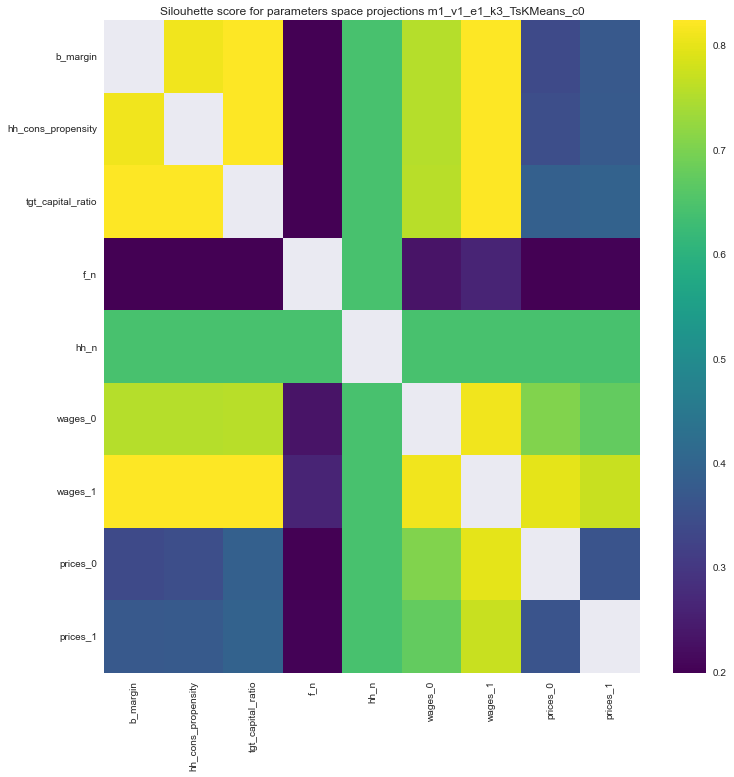

In [18]:
from tsma.analyses.clustering import get_best_vars_4_proj

df_score_proj, auto_lst_var = get_best_vars_4_proj(
    df_params_clustered, clusterings, 3, clust_code, heatmap=True, size=12
)

print(
    f"the best variables for projections of the parameters space are :\n {auto_lst_var[1:]}"
)

## 5 Phase Diagram

**phase_diag_pairplot** is finally used to create the phase diagram.
- on the diagonal there is a density estimation of a given variable.
- on the other plots a bivariate distributions by kernel density estimation (KDE) are showed.
- the upper KDE has a higher density threshold and thus shows the main clusters only.

LinAlgError: singular matrix

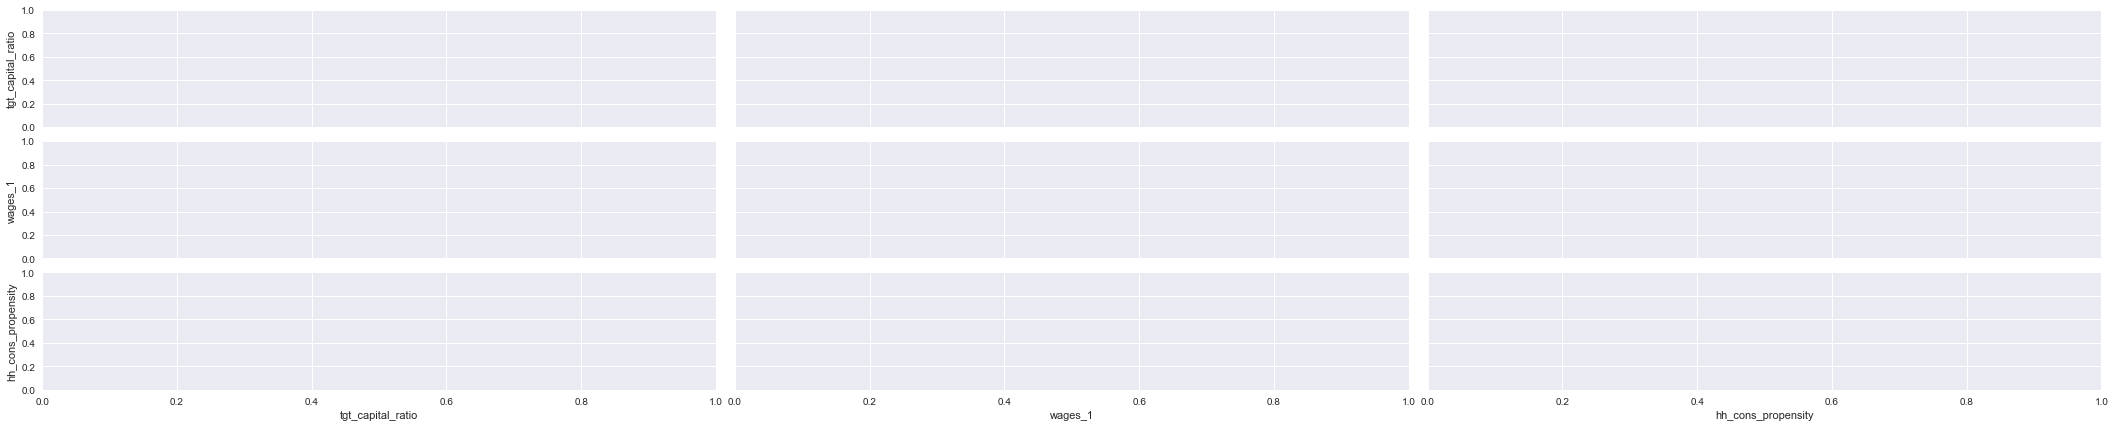

In [19]:
from tsma.visuals.figures import phase_diag_pairplot

phase_diag_pairplot(
    df_params_clustered.loc[:, auto_lst_var],
    clust_code,
    size = 10,
    height=2,
    aspect=5,
    thr_low=0.2,
    thr_upp=0.5,
    alpha_low=0.2,
    alpha_upp=0.4,
    palette="viridis", #Spectral, viridis
)